# Minimal example for fitting with `squirrel`
 
This notebook requires the "./data/mock_datacube.fits" file. The notebook "simulate_mock_datacube.ipynb" needs to be run to create that datacube.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ppxf.sps_util as sps_util
from astropy.io import fits

import squirrel
from squirrel.pipeline import Pipeline
from squirrel.data import Datacube
from squirrel.template import Template

squirrel.__version__

'0.0.0'

## Load data

In [2]:
data, header = fits.getdata("./data/mock_datacube.fits", header=True)
noise = fits.getdata("./data/mock_datacube.fits", ext=1)

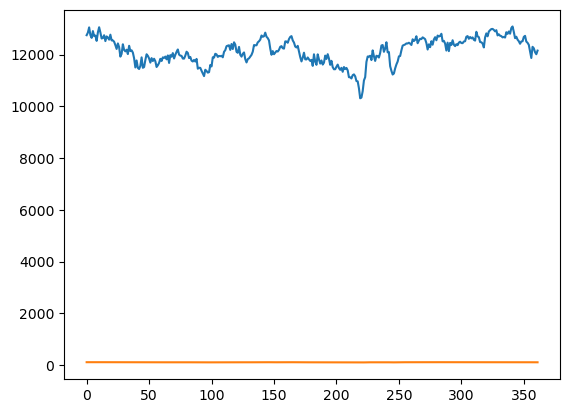

In [3]:
plt.plot(data[:, 17, 17])
plt.plot(noise[:, 17, 17])

In [4]:
data.shape

(362, 35, 35)

## Create a `Datacube` object

Alternative object type is `Spectra` if working with an integated spectra.

In [5]:
wavelengths = (
    header["CRVAL3"] + header["CDELT3"] * (1 + np.arange(header["NAXIS3"]))
) * 1e4

z_lens = 0.3
z_source = 1.0

fwhm = (wavelengths[1] - wavelengths[0]) * 2

center_pixel_x = 17
center_pixel_y = 17

coordinate_transform_matrix = (
    np.array([[header["PC1_1"], header["PC1_2"]], [header["PC2_1"], header["PC2_2"]]])
    * header["CDELT1"]
    * 3600
)

datacube = Datacube(
    wavelengths=wavelengths,
    flux=data,
    wavelength_unit="AA",
    flux_unit=header["BUNIT"],
    noise=noise,
    fwhm=fwhm,
    z_lens=z_lens,
    z_source=z_source,
    center_pixel_x=center_pixel_x,
    center_pixel_y=center_pixel_y,
    coordinate_transform_matrix=coordinate_transform_matrix,
)

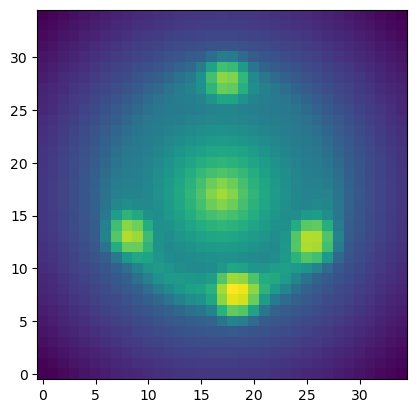

In [6]:
plt.imshow(
    np.sqrt(datacube.x_coordinates**2 + datacube.y_coordinates**2),
    origin="lower",
)
plt.imshow(np.log10(np.nansum(datacube.flux, axis=0)), origin="lower")

## Process datacube

For example, clip wavelength range, de-redshift the wavelength, etc.

In [7]:
datacube.reset()
datacube.deredshift(target_frame="lens")
datacube.clip(wavelength_min=8200, wavelength_max=8950)

datacube.flux.shape

(153, 35, 35)

In [8]:
datacube.spectra_modifications, datacube.wavelengths_frame

(['clipped'], 'lens frame')

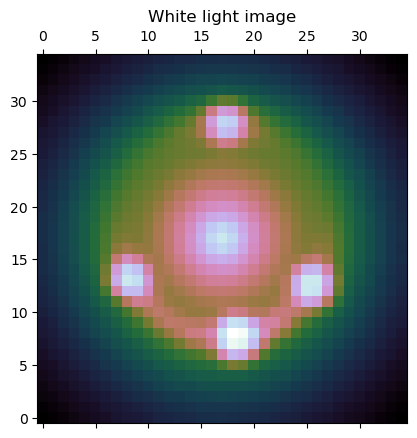

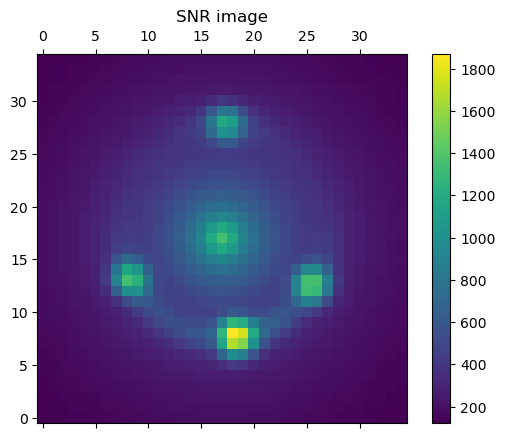

In [9]:
ax = plt.subplot(111)

ax.matshow(
    np.log10(np.nansum(datacube.flux, axis=0)),
    origin="lower",
    aspect="equal",
    cmap="cubehelix",
)
ax.set_title("White light image")
plt.show()

ax = plt.subplot(111)
im = ax.matshow(
    np.nansum(datacube.flux, axis=0) / np.sqrt(np.nansum(datacube.noise**2, axis=0)),
    origin="lower",
    aspect="equal",
    cmap="viridis",
)
ax.set_title("SNR image")
plt.colorbar(im)
plt.show()

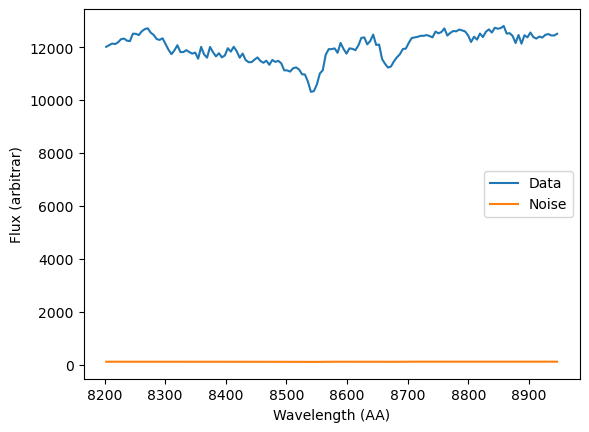

In [10]:
ax = plt.subplot(111)

ax.plot(
    datacube.wavelengths,
    datacube.flux[:, 17, 17],
    label="Data",
)

ax.plot(datacube.wavelengths, datacube.noise[:, 17, 17], label="Noise")
ax.set_xlabel(f"Wavelength ({datacube.wavelength_unit})")
ax.set_ylabel(f"Flux ({datacube.flux_unit})")
ax.legend()

## do Voronoi binning

Bin-accretion...
1  /  158
2  /  158
3  /  158
4  /  158
5  /  158
6  /  158
7  /  158
8  /  158
9  /  158
10  /  158
11  /  158
12  /  158
13  /  158
14  /  158
15  /  158
16  /  158
17  /  158
18  /  158
19  /  158
20  /  158
21  /  158
22  /  158
23  /  158
24  /  158
25  /  158
26  /  158
27  /  158
28  /  158
29  /  158
30  /  158
31  /  158
32  /  158
33  /  158
34  /  158
35  /  158
36  /  158
37  /  158
38  /  158
39  /  158
40  /  158
41  /  158
42  /  158
43  /  158
44  /  158
45  /  158
46  /  158
47  /  158
48  /  158
49  /  158
50  /  158
51  /  158
52  /  158
53  /  158
54  /  158
55  /  158
56  /  158
57  /  158
58  /  158
59  /  158
60  /  158
61  /  158
62  /  158
63  /  158
64  /  158
65  /  158
66  /  158
67  /  158
68  /  158
69  /  158
70  /  158
71  /  158
72  /  158
73  /  158
74  /  158
75  /  158
76  /  158
77  /  158
78  /  158
79  /  158
80  /  158
81  /  158
82  /  158
83  /  158
84  /  158
85  /  158
86  /  158
87  /  158
88  /  158
89  /  158
90  /  158
91

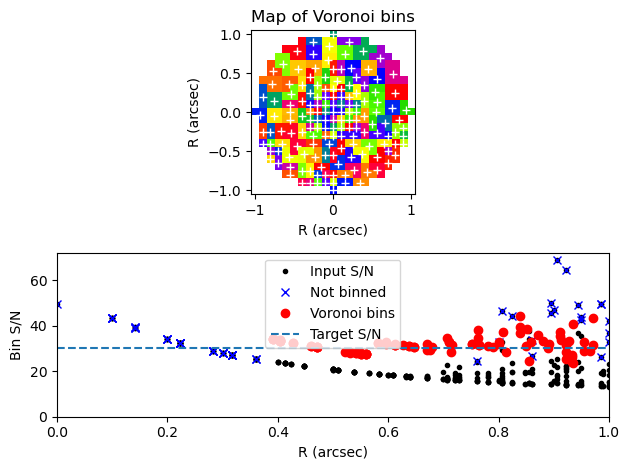

In [11]:
np.random.seed(0)

signal_image = np.nansum(datacube.flux, axis=0) / np.sqrt(
    datacube.wavelengths[-1] - datacube.wavelengths[0]
)
noise_image = np.sqrt(np.nansum(datacube.noise**2, axis=0))

bin_mapping_outputs = Pipeline.get_voronoi_binning_map(
    datacube,
    signal_image_per_wavelength_unit=signal_image,
    noise_image=noise_image,
    target_snr=30,
    max_radius=1,
    min_snr_per_spaxel=1.0,
    plot=True,
    quiet=False,
)

In [12]:
voronoi_binned_spectra = Pipeline.get_voronoi_binned_spectra(
    datacube, bin_mapping_outputs
)

voronoi_binned_spectra.flux.shape

(153, 153)

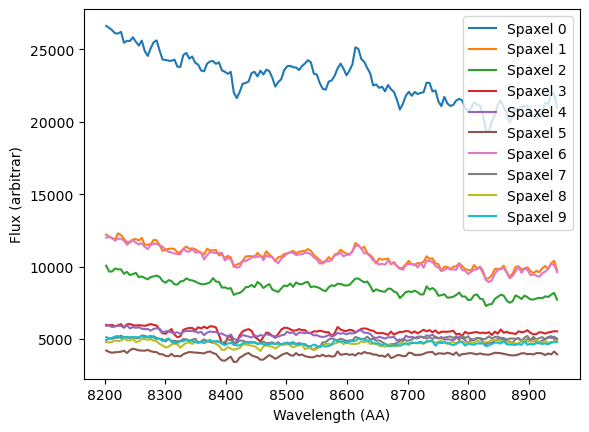

In [13]:
for i in range(10):
    plt.plot(
        voronoi_binned_spectra.wavelengths,
        voronoi_binned_spectra.flux[:, i],
        label=f"Spaxel {i}",
    )
plt.xlabel(f"Wavelength ({voronoi_binned_spectra.wavelength_unit})")
plt.ylabel(f"Flux ({voronoi_binned_spectra.flux_unit})")
plt.legend()
plt.show()

## create stellar `Template` object

In [14]:
Pipeline.log_rebin(voronoi_binned_spectra, num_samples_for_covariance=1000)

100%|██████████| 153/153 [00:02<00:00, 59.09it/s]


In [15]:
voronoi_binned_spectra.spectra_modifications, datacube.wavelengths_frame

(['clipped', 'log_rebinned'], 'lens frame')

In [16]:
voronoi_binned_spectra.flux.shape, voronoi_binned_spectra.wavelengths.shape

((153, 153), (153,))

In [17]:
wavelength_range_templates = (
    voronoi_binned_spectra.wavelengths[0] / 1.2,
    voronoi_binned_spectra.wavelengths[-1] * 1.2,
)

sps_name = "emiles"

template_filename = (
    f"/Users/ajshajib/Vault/research/stellar_atlas/ssp/spectra_{sps_name}_9.0.npz"
)

template = Pipeline.get_template_from_library(
    template_filename,
    voronoi_binned_spectra.get_single_spectra(0),
    velocity_scale_ratio=2,
    wavelength_factor=1,
    wavelength_range_extend_factor=1.05,
)

print(template.flux.shape)

(646, 150)


## Fit the spectrwa with `ppxf`

 Best Fit:       Vel     sigma
 comp.  0:       100       402
chi2/DOF: 1.254; DOF: 151; degree = 4; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/150


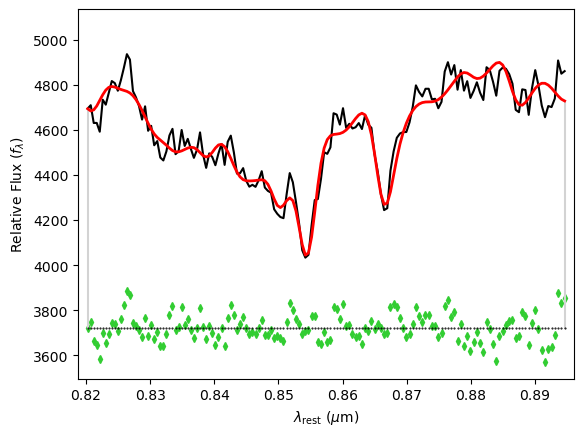

In [18]:
ppxf_fit = Pipeline.run_ppxf(
    voronoi_binned_spectra,
    template,
    start=[0, 200],
    degree=4,
    spectra_indices=20,
    quiet=False,
)

ppxf_fit.plot()
plt.show()